In [1]:
from mxnet import autograd, np, npx
from d2l import mxnet as d2l
npx.set_np()

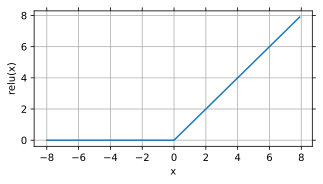

In [2]:
x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = npx.relu(x)
d2l.plot(x, y, 'x', 'relu(x)', figsize=(5, 2.5))

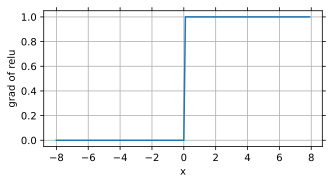

In [3]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

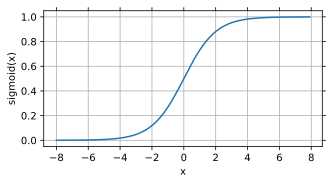

In [4]:
with autograd.record():
    y = npx.sigmoid(x)
d2l.plot(x, y, 'x', 'sigmoid(x)', figsize=(5, 2.5))

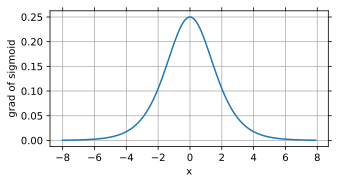

In [5]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))


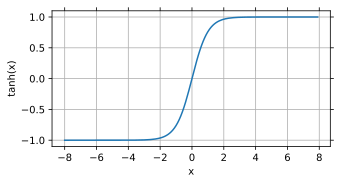

In [6]:
with autograd.record():
    y = np.tanh(x)
d2l.plot(x, y, 'x', 'tanh(x)', figsize=(5, 2.5))

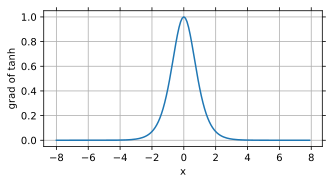

In [7]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))


Polynomial Regression

In [9]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()


In [10]:
max_degree = 20 # Maximum degree of the polynomial
n_train, n_test = 100, 100 # Training and test dataset sizes
true_w = np.zeros(max_degree) # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [11]:
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.7205708],
        [ 1.6839303]]),
 array([[ 1.00000000e+00, -7.20570803e-01,  2.59611130e-01,
         -6.23560697e-02,  1.12329908e-02, -1.61883293e-03,
          1.94413966e-04, -2.00127197e-05,  1.80257257e-06,
         -1.44320126e-07,  1.03992877e-08, -6.81220247e-10,
          4.09056192e-11, -2.26733801e-12,  1.16698399e-13,
         -5.60596389e-15,  2.52468361e-16, -1.07012554e-17,
          4.28389576e-19, -1.62465785e-20],
        [ 1.00000000e+00,  1.68393028e+00,  1.41781056e+00,
          7.95831382e-01,  3.35031152e-01,  1.12833820e-01,
          3.16673815e-02,  7.61795137e-03,  1.60351233e-03,
          3.00022541e-04,  5.05217067e-05,  7.73409374e-06,
          1.08530617e-06,  1.40583083e-07,  1.69094356e-08,
          1.89828731e-09,  1.99786493e-10,  1.97897948e-11,
          1.85136867e-12,  1.64082926e-13]]),
 array([2.8589308, 6.8470483]))

In [12]:
def evaluate_loss(net, data_iter, loss): #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2) # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), l.size)
    return metric[0] / metric[1]


In [13]:
def train(train_features, test_features, train_labels, test_labels,num_epochs=400):
    
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',{'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
    xlim=[1, num_epochs], ylim=[1e-3, 1e2],
    legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

weight: [[ 5.040995   1.4447024 -3.4685585  5.035459 ]]


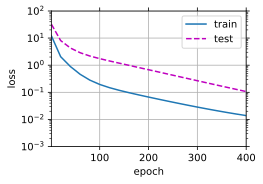

In [14]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])


Linear Function Fitting (Underfitting)

weight: [[3.1879678 3.5147598]]


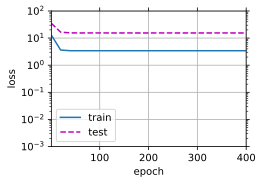

In [15]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting (Overfitting)

weight: [[ 4.9504776   1.288189   -3.1184177   5.191426   -0.8859496   1.2285511
  -0.13371202  0.15534738  0.01579423 -0.02290048  0.00525169 -0.05160682
  -0.02441274 -0.01501499 -0.04941951  0.06389688 -0.04761819 -0.04380167
  -0.05188227  0.05655775]]


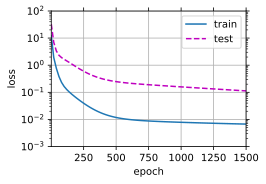

In [16]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)


High-Dimensional Linear Regression

In [17]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()

In [18]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)


In [20]:
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]


In [21]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [27]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 1000, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
        d2l.sgd([w, b], lr, batch_size)
    if (epoch + 1) % 5 == 0:
        animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', np.linalg.norm(w))


L2 norm of w: 13.253081


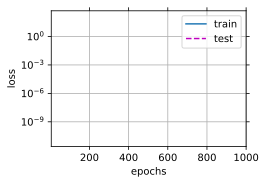

In [28]:
train(lambd=0)

L2 norm of w: 0.027087957


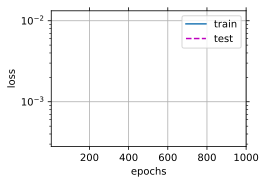

In [29]:
train(lambd=3)

Concise Implementation

In [25]:
def train_concise(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr,'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', np.linalg.norm(net[0].weight.data()))

L2 norm of w: 11.472789


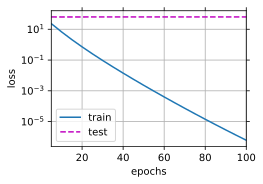

In [26]:
train_concise(0)

L2 norm of w: 0.3805175


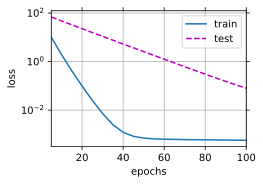

In [30]:
train_concise(3)

Dropout Implementation from Scratch

In [31]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()

In [32]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return np.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = np.random.uniform(0, 1, X.shape) > dropout
    return mask.astype(np.float32) * X / (1.0 - dropout)

In [33]:
X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  2.  0.  6.  8.  0.  0. 14.]
 [16.  0.  0. 22.  0.  0. 28. 30.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


Defining Model Parameters

In [34]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)
params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

Defining the Model

In [35]:
dropout1, dropout2 = 0.2, 0.5
def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout_layer(H2, dropout2)
    return np.dot(H2, W3) + b3

Concise Implementation

In [37]:
net = nn.Sequential()
net.add(
nn.Dense(256, activation="relu"),
# Add a dropout layer after the first fully connected layer
nn.Dropout(dropout1), nn.Dense(256, activation="relu"),
# Add a dropout layer after the second fully connected layer
nn.Dropout(dropout2), nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

AssertionError: 0.0

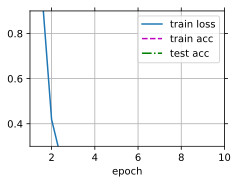

In [38]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

Vanishing Gradients

In [39]:
from mxnet import autograd, np, npx
from d2l import mxnet as d2l

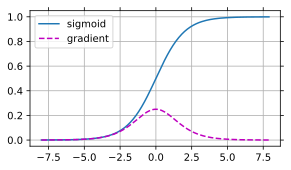

In [40]:
npx.set_np()
x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = npx.sigmoid(x)
y.backward()
d2l.plot(x, [y, x.grad], legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

Exploding Gradients

In [41]:
M = np.random.normal(size=(4, 4))
print('a single matrix', M)
for i in range(100):
    M = np.dot(M, np.random.normal(size=(4, 4)))
print('after multiplying 100 matrices', M)

a single matrix [[ 8.2408702e-03  1.4635234e+00 -6.2115961e-01 -1.7108936e+00]
 [-1.1157038e+00  7.0147347e-01  2.0752997e+00  1.1949824e+00]
 [ 1.7324601e-03  4.5738000e-01  1.2032342e+00  1.0317332e+00]
 [ 2.1366547e-01  6.8604106e-01 -9.0585810e-01 -5.4902750e-01]]
after multiplying 100 matrices [[ 1.59493821e+24  7.68631957e+24  4.01133702e+24 -2.51808663e+24]
 [ 6.79516758e+22  3.27472293e+23  1.70901212e+23 -1.07282039e+23]
 [-1.23525379e+24 -5.95292745e+24 -3.10671359e+24  1.95021717e+24]
 [-4.24683896e+23 -2.04663397e+24 -1.06809725e+24  6.70490364e+23]]
